2025-05-30 21:39:01,128 - INFO - Data loaded successfully. Shape: (1407328, 6)
2025-05-30 21:39:01,129 - INFO - Performing basic analysis...
2025-05-30 21:39:01,755 - INFO - Headline length statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64
2025-05-30 21:39:01,842 - INFO - Top publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


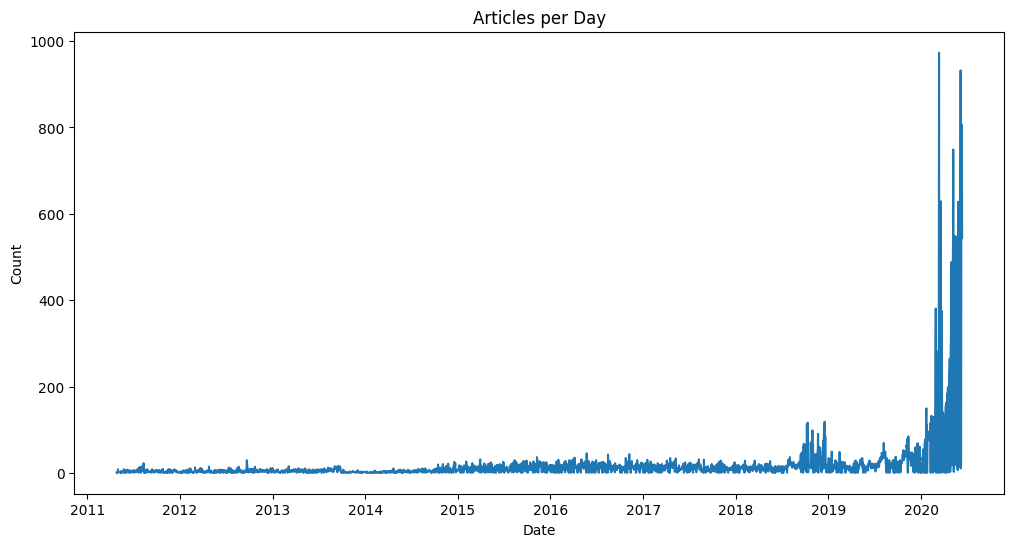

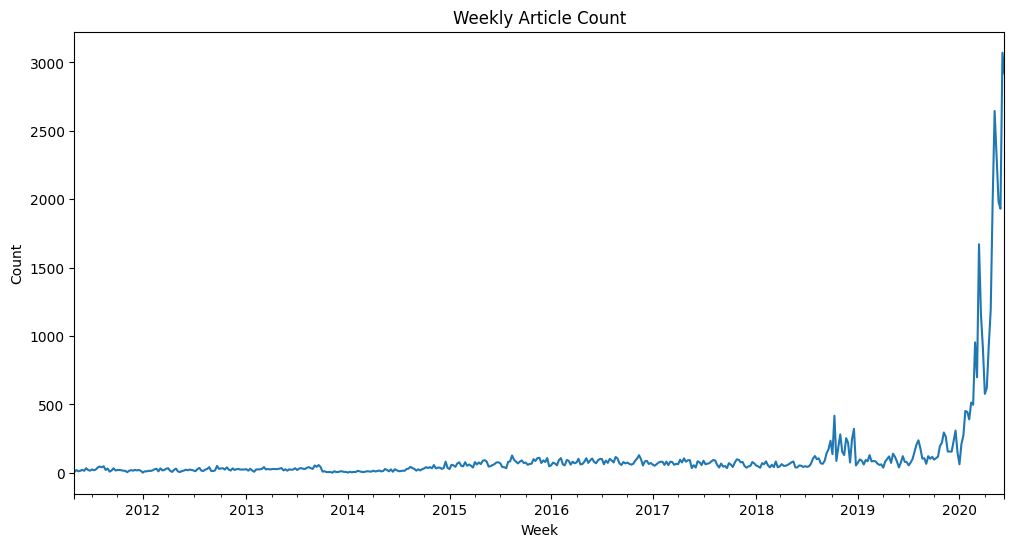

2025-05-30 21:39:06,200 - INFO - Starting text analysis...
2025-05-30 21:39:07,092 - INFO - Performing sentiment analysis...


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


KeyboardInterrupt: 

In [2]:
"""
Financial News Analysis Pipeline

This script performs comprehensive analysis on financial news data including:
- Descriptive statistics
- Time series analysis
- Text and sentiment analysis
- Publisher analysis
- Correlation with stock movements

Usage:
    python eda_modular.py --input data/raw/raw_analyst_ratings.csv [--stock-data stock_prices.csv]

Dependencies:
    See requirements.txt
"""

import os
import sys
sys.path.append('../src')
import ed_function as eda  # Our custom EDA functions
import logging
from pathlib import Path
import argparse
import pandas as pd
import nltk
from tqdm import tqdm

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("financial_news_analysis.log"),
        logging.StreamHandler(sys.stdout)
    ]
)

def configure_arguments():
    """Set up command line argument parsing."""
    parser = argparse.ArgumentParser(description='Financial News Analysis')
    parser.add_argument('--input', required=True, help='Path to news data CSV')
    parser.add_argument('--stock-data', help='Path to stock data CSV for correlation analysis')
    return parser.parse_args()

def load_and_validate_data(filepath: Path) -> pd.DataFrame:
    """
    Load data with validation checks.
    
    Args:
        filepath: Path to data file
        
    Returns:
        Loaded DataFrame
        
    Raises:
        FileNotFoundError: If file doesn't exist
        ValueError: If data loading fails
    """
    if not filepath.exists():
        raise FileNotFoundError(f"Data file not found at {filepath}")
    
    try:
        df = eda.load_data(filepath)
        logging.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        raise ValueError(f"Failed to load data: {str(e)}")

def perform_basic_analysis(df: pd.DataFrame) -> None:
    """Run fundamental descriptive analysis."""
    logging.info("Performing basic analysis...")
    
    # Headline length analysis
    df = eda.add_headline_length(df)
    logging.info(f"Headline length statistics:\n{eda.describe_headline_length(df)}")
    
    # Publisher analysis
    publisher_counts = eda.count_articles_per_publisher(df)
    logging.info(f"Top publishers:\n{publisher_counts.head(10)}")
    
    # Date analysis
    df = eda.parse_date_column(df)
    eda.plot_articles_per_day(df)
    eda.plot_weekly_article_count(df)


def perform_text_analysis(df: pd.DataFrame) -> None:
    """
    Perform text analysis on the dataset:
    - Sentiment Analysis using VADER and TextBlob
    - Topic Modeling via keyword extraction
    - Visualization of results
    
    Args:
        df: DataFrame containing the news data with a 'headline' column
    """
    logging.info("Starting text analysis...")
    
    # Initialize sentiment analyzer
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()
    
    # Add sentiment scores
    logging.info("Performing sentiment analysis...")
    df['sentiment_vader'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
    df['sentiment_textblob'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Summarize sentiment results
    sentiment_summary = df[['sentiment_vader', 'sentiment_textblob']].describe()
    logging.info(f"Sentiment analysis summary:\n{sentiment_summary}")
    
    # Plot sentiment distribution
    logging.info("Plotting sentiment distributions...")
    plt.figure(figsize=(10, 6))
    plt.hist(df['sentiment_vader'], bins=30, alpha=0.5, label='VADER Sentiment')
    plt.hist(df['sentiment_textblob'], bins=30, alpha=0.5, label='TextBlob Sentiment')
    plt.legend(loc='upper right')
    plt.title("Sentiment Score Distribution")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.savefig('results/sentiment_distribution.png')
    plt.close()

    # Extract keywords using TF-IDF
    logging.info("Extracting top keywords...")
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5)
    tfidf_matrix = vectorizer.fit_transform(df['headline'])
    keywords = vectorizer.get_feature_names_out()
    keyword_scores = tfidf_matrix.sum(axis=0).A1
    keyword_df = pd.DataFrame({'Keyword': keywords, 'Score': keyword_scores})
    keyword_df.sort_values(by='Score', ascending=False, inplace=True)
    
    logging.info(f"Top keywords:\n{keyword_df}")
    
    # Visualize top keywords
    plt.figure(figsize=(10, 6))
    plt.barh(keyword_df['Keyword'], keyword_df['Score'], color='teal')
    plt.gca().invert_yaxis()
    plt.title("Top Keywords by TF-IDF Score")
    plt.xlabel("Score")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.savefig('results/top_keywords.png')
    plt.close()
    
    logging.info("Text analysis completed successfully.")


def perform_correlation_analysis(news_df: pd.DataFrame, stock_data_path: Path) -> None:
    """Analyze correlation between news sentiment and stock data."""
    try:
        stock_df = pd.read_csv(stock_data_path, parse_dates=['Date'])
        stock_df['daily_return'] = stock_df['Close'].pct_change()
        
        # Merge data on date
        merged_df = pd.merge(
            news_df,
            stock_df,
            left_on=eda.parse_date_column(news_df)['date'].dt.date,
            right_on=stock_df['Date'].dt.date
        )
        
        # Calculate correlations
        corr = merged_df[['sentiment_vader', 'sentiment_textblob', 'daily_return']].corr()
        logging.info(f"Correlation matrix:\n{corr}")
        
        # Plot correlation heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title('Sentiment-Stock Return Correlation')
        plt.savefig('results/sentiment_correlation.png')
        plt.close()
        
    except Exception as e:
        logging.warning(f"Correlation analysis skipped: {str(e)}")

def main(input_path="../data/raw/raw_analyst_ratings.csv", stock_data_path=None):
    try:
        
        # Load and validate data
        df = load_and_validate_data(Path(input_path))
        
        # Perform analyses
        perform_basic_analysis(df)
        perform_text_analysis(df)
        
        # Optional correlation analysis
        if stock_data_path:
            perform_correlation_analysis(df, Path(stock_data_path))
        
        logging.info("Analysis completed successfully")
        return df  # Return dataframe for further inspection in notebook
        
    except Exception as e:
        logging.error(f"Analysis failed: {str(e)}")
        raise  # Re-raise exception for notebook debugging

# For Jupyter notebook usage:
if __name__ == "__main__" and '__file__' not in globals():
    # This will run when in notebook environment
    df = main()  # Use default paths or specify your own
else:
    # This will run when executed from command line
    if __name__ == "__main__":
        args = configure_arguments()
        main(args.input, args.stock_data)

